### Spatial Correlation simulation

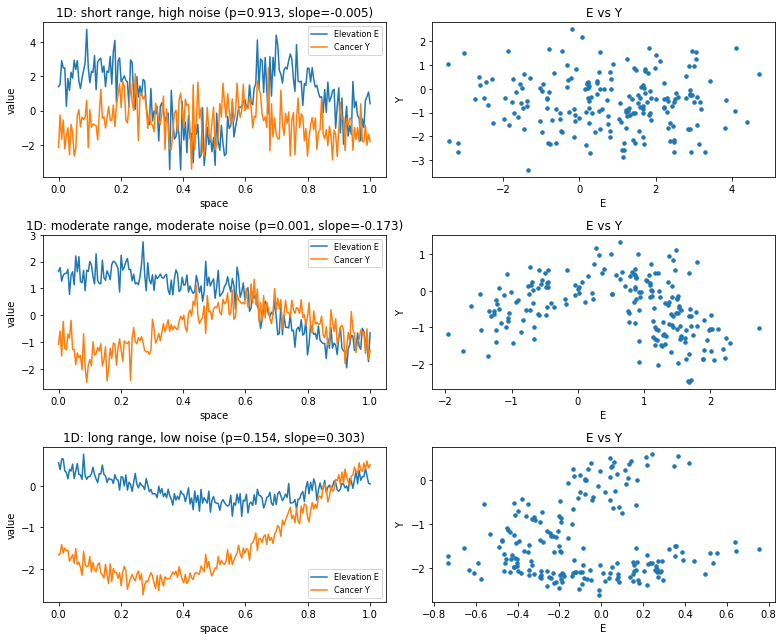

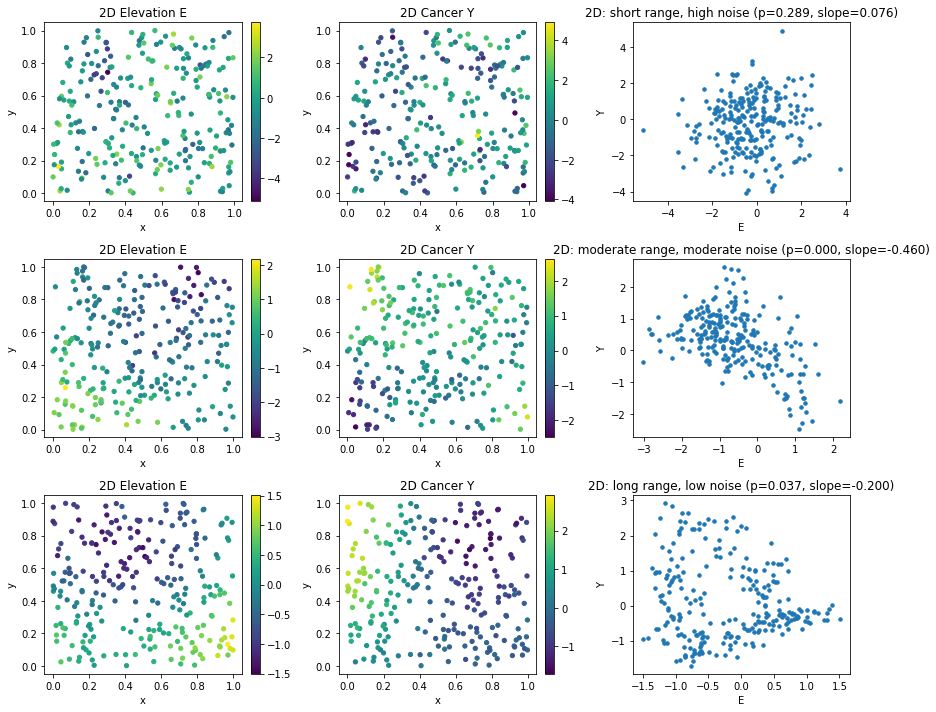

100%|██████████| 2000/2000 [00:15<00:00, 131.29it/s]


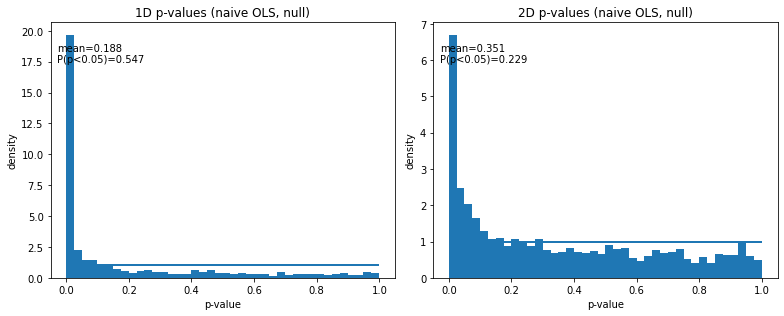

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import cholesky
from scipy.stats import t as student_t
import statsmodels.api as sm
import tqdm 
# -------------------------
# Spatial GP helpers (RBF)
# -------------------------
def rbf_cov(coords, ell=0.25, sigma=1.0, nugget=1e-10):
    """
    coords: (n,d)
    RBF kernel: sigma^2 * exp(-||si-sj||^2/(2 ell^2))
    """
    diffs = coords[:, None, :] - coords[None, :, :]
    d2 = np.sum(diffs**2, axis=-1)
    K = (sigma**2) * np.exp(-0.5 * d2 / (ell**2))
    K = K + nugget * np.eye(coords.shape[0])
    return K

def gp_draw(coords, ell=0.25, sigma=1.0):
    K = rbf_cov(coords, ell=ell, sigma=sigma)
    L = cholesky(K, lower=True, check_finite=False)
    return L @ np.random.randn(coords.shape[0])

# -------------------------
# Naive OLS p-value (using statsmodels)
# -------------------------
def naive_ols_pvalue(E, Y):
    """
    p-value for slope in Y ~ 1 + E, using statsmodels OLS (iid SE).
    Returns: (p-value, slope, t-statistic)
    """
    
    E = np.asarray(E)
    Y = np.asarray(Y)
    X = sm.add_constant(E)  # adds intercept
    model = sm.OLS(Y, X)
    res = model.fit()
    # slope is at index 1 (index 0 is the intercept)
    p = float(res.pvalues[1])
    beta1 = float(res.params[1])
    tstat = float(res.tvalues[1])
    return p, beta1, tstat

# -------------------------
# Data generation: Variant B
# E and Y are spatially correlated, but independent of each other
# -------------------------
def simulate_1d(n=200, ell_e=0.25, ell_y=0.25, noise_e=0.3, noise_y=0.3):
    x = np.linspace(0, 1, n)[:, None]
    E = gp_draw(x, ell=ell_e) + noise_e * np.random.randn(n)
    Y = gp_draw(x, ell=ell_y) + noise_y * np.random.randn(n)
    return x[:, 0], E, Y

def simulate_2d(n=250, ell_e=0.25, ell_y=0.25, noise_e=0.3, noise_y=0.3):
    coords = np.random.rand(n, 2)
    E = gp_draw(coords, ell=ell_e) + noise_e * np.random.randn(n)
    Y = gp_draw(coords, ell=ell_y) + noise_y * np.random.randn(n)
    return coords, E, Y

# -------------------------
# Example plots (what the data looks like)
# -------------------------
def example_plots():
    settings = [
        dict(ell_e=0.08, ell_y=0.08, noise_e=1.0, noise_y=1.0, title="short range, high noise"),
        dict(ell_e=0.25, ell_y=0.25, noise_e=0.4, noise_y=0.4, title="moderate range, moderate noise"),
        dict(ell_e=0.40, ell_y=0.40, noise_e=0.15, noise_y=0.15, title="long range, low noise"),
    ]

    # --- 1D examples ---
    fig = plt.figure(figsize=(11, 9))
    for i, s in enumerate(settings, start=1):
        x, E, Y = simulate_1d(n=200, **{k:v for k,v in s.items() if k != "title"})
        p, b1, _ = naive_ols_pvalue(E, Y)

        ax1 = fig.add_subplot(3, 2, 2*i-1)
        ax1.plot(x, E, label="Elevation E")
        ax1.plot(x, Y, label="Cancer Y")
        ax1.set_title(f"1D: {s['title']} (p={p:.3f}, slope={b1:.3f})")
        ax1.set_xlabel("space")
        ax1.set_ylabel("value")
        ax1.legend(fontsize=8)

        ax2 = fig.add_subplot(3, 2, 2*i)
        ax2.scatter(E, Y, s=12)
        ax2.set_title("E vs Y")
        ax2.set_xlabel("E")
        ax2.set_ylabel("Y")

    plt.tight_layout()
    plt.show()

    # --- 2D examples ---
    fig = plt.figure(figsize=(12, 10))
    for i, s in enumerate(settings, start=1):
        coords, E, Y = simulate_2d(n=250, **{k:v for k,v in s.items() if k != "title"})
        p, b1, _ = naive_ols_pvalue(E, Y)

        ax1 = fig.add_subplot(3, 3, 3*i-2)
        sc1 = ax1.scatter(coords[:,0], coords[:,1], c=E, s=18)
        ax1.set_title("2D Elevation E")
        ax1.set_xlabel("x"); ax1.set_ylabel("y")
        plt.colorbar(sc1, ax=ax1, fraction=0.046, pad=0.04)

        ax2 = fig.add_subplot(3, 3, 3*i-1)
        sc2 = ax2.scatter(coords[:,0], coords[:,1], c=Y, s=18)
        ax2.set_title("2D Cancer Y")
        ax2.set_xlabel("x"); ax2.set_ylabel("y")
        plt.colorbar(sc2, ax=ax2, fraction=0.046, pad=0.04)

        ax3 = fig.add_subplot(3, 3, 3*i)
        ax3.scatter(E, Y, s=12)
        ax3.set_title(f"2D: {s['title']} (p={p:.3f}, slope={b1:.3f})")
        ax3.set_xlabel("E"); ax3.set_ylabel("Y")

    plt.tight_layout()
    plt.show()

# -------------------------
# Monte Carlo: histogram of p-values + uniform reference
# -------------------------
def pvalue_histograms(R=3000,
                      # 1D params
                      n1=200, ell_e1=0.08, ell_y1=0.8, noise_e1=0.4, noise_y1=1,
                      # 2D params
                      n2=220, ell_e2=0.08, ell_y2=0.08, noise_e2=0.4, noise_y2=1):
    p1 = np.empty(R)
    p2 = np.empty(R)

    for r in tqdm.tqdm(range(R)):
        _, E, Y = simulate_1d(n=n1, ell_e=ell_e1, ell_y=ell_y1, noise_e=noise_e1, noise_y=noise_y1)
        p1[r], _, _ = naive_ols_pvalue(E, Y)

        _, E, Y = simulate_2d(n=n2, ell_e=ell_e2, ell_y=ell_y2, noise_e=noise_e2, noise_y=noise_y2)
        p2[r], _, _ = naive_ols_pvalue(E, Y)

    fig = plt.figure(figsize=(11, 4.5))

    ax = fig.add_subplot(1,2,1)
    ax.hist(p1, bins=40, density=True)
    ax.hlines(1.0, 0, 1, linewidth=2)  # Uniform(0,1) density
    ax.set_title("1D p-values (naive OLS, null)")
    ax.set_xlabel("p-value")
    ax.set_ylabel("density")
    ax.text(0.02, 0.92, f"mean={p1.mean():.3f}\nP(p<0.05)={(p1<0.05).mean():.3f}",
            transform=ax.transAxes, va="top")

    ax = fig.add_subplot(1,2,2)
    ax.hist(p2, bins=40, density=True)
    
    ax.hlines(1.0, 0, 1, linewidth=2)
    ax.set_title("2D p-values (naive OLS, null)")
    ax.set_xlabel("p-value")
    ax.set_ylabel("density")
    ax.text(0.02, 0.92, f"mean={p2.mean():.3f}\nP(p<0.05)={(p2<0.05).mean():.3f}",
            transform=ax.transAxes, va="top")

    plt.tight_layout()
    plt.show()

    return p1, p2

if __name__ == "__main__":
    np.random.seed(0)

    example_plots()

    p1, p2 = pvalue_histograms(R=2000,
                              n1=200, ell_e1=0.08, ell_y1=0.08, noise_e1=0.4, noise_y1=1,
                              n2=220, ell_e2=0.08, ell_y2=0.08, noise_e2=0.4, noise_y2=1)


In [ ]:
"""
Simulation of "forced-in elevation" + best-subset + BIC-min model selection + one-tailed t-test
for negative elevation coefficient; then histogram of p-values and false-positive rates.

Requires:
  pip install numpy scipy statsmodels matplotlib
"""

import itertools
import numpy as np
from numpy.random import default_rng
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt


# ---------------------------
# 1) Data generation helpers
# ---------------------------

def make_correlated_design(n: int, p: int, rho: float, rng: np.random.Generator):
    """
    Generate correlated covariates [E, X1..Xp] from a (p+1)-dim MVN with AR(1) correlation.
    Moderate collinearity when rho ~ 0.3-0.7.

    Returns:
      E: shape (n,)
      X: shape (n, p)
    """
    d = p + 1
    Sigma = np.fromfunction(lambda i, j: rho ** np.abs(i - j), (d, d), dtype=float)
    Z = rng.multivariate_normal(mean=np.zeros(d), cov=Sigma, size=n)

    E = Z[:, 0]
    X = Z[:, 1:]
    return E, X


def standardize_cols(E, X, y):
    """
    Standardize columns to mean 0, sd 1 (optional but stabilizes numerics).
    """
    def z(v):
        s = v.std(ddof=0)
        return (v - v.mean()) / (s if s > 0 else 1.0)

    E_z = z(E)
    X_z = np.column_stack([z(X[:, j]) for j in range(X.shape[1])])
    y_z = z(y)
    return E_z, X_z, y_z


def generate_outcome(E, X, signal_idx, beta_x, sigma, rng: np.random.Generator):
    """
    y = sum_{j in signal_idx} beta_x[j] * X_j + eps
    True effect of E is exactly zero.
    """
    n, p = X.shape
    y = np.zeros(n)
    for j in signal_idx:
        y += beta_x[j] * X[:, j]
    y += rng.normal(0.0, sigma, size=n)
    return y


# -----------------------------------------
# 2) Forced-E best subset + BIC selection
# -----------------------------------------

def fit_bic_best_subset_forced_E(y, E, X):
    """
    Enumerate all subsets of X columns, always include intercept + E.
    Select the subset with minimal BIC.

    Returns:
      best_res: statsmodels RegressionResults
      best_subset: tuple of selected X indices
      best_bic: float
    """
    n, p = X.shape
    best_bic = np.inf
    best_res = None
    best_subset = None

    # Enumerate all subsets: sizes 0..p
    for k in range(p + 1):
        for subset in itertools.combinations(range(p), k):
            cols = [E] + [X[:, j] for j in subset]
            X_design = np.column_stack(cols)
            X_design = sm.add_constant(X_design, has_constant="add")

            res = sm.OLS(y, X_design).fit()
            bic = res.bic

            if bic < best_bic:
                best_bic = bic
                best_res = res
                best_subset = subset

    return best_res, best_subset, best_bic


def one_tailed_pvalue_negative_beta(beta_hat, se_hat, df_resid):
    """
    One-tailed p-value for H1: beta < 0 (negative coefficient).
    """
    t_stat = beta_hat / se_hat
    # p = P(T <= t_obs)
    return stats.t.cdf(t_stat, df=df_resid)


# ---------------------------
# 3) One replicate
# ---------------------------

def run_one_replicate(
    n=260,
    p=10,
    rho=0.5,
    signal_idx=(0, 1, 2),
    beta_signal=(0.6, 0.5, 0.4),
    sigma=1.0,
    standardize=True,
    rng=None,
):
    """
    Generate (E, X1..Xp) with collinearity; generate y with real signal in X but true beta_E=0;
    run forced-E best-subset, pick BIC-min model, one-tailed test for negative beta_E.

    Returns:
      pval_E (float), chosen_subset (tuple), beta_E_hat (float)
    """
    if rng is None:
        rng = default_rng()

    E, X = make_correlated_design(n=n, p=p, rho=rho, rng=rng)

    beta_x = np.zeros(p)
    for j, b in zip(signal_idx, beta_signal):
        beta_x[j] = b

    y = generate_outcome(E, X, signal_idx=signal_idx, beta_x=beta_x, sigma=sigma, rng=rng)

    if standardize:
        E, X, y = standardize_cols(E, X, y)

    res, subset, _bic = fit_bic_best_subset_forced_E(y=y, E=E, X=X)

    # Parameter order: const, E, then chosen X's in the subset order we stacked
    beta_E_hat = res.params[1]
    se_E_hat = res.bse[1]
    pval = one_tailed_pvalue_negative_beta(beta_E_hat, se_E_hat, res.df_resid)

    return float(pval), subset, float(beta_E_hat)


# ---------------------------
# 4) Monte Carlo experiment
# ---------------------------

def run_simulation(
    n_sims=5000,
    n=260,
    p=10,
    rho=0.5,
    signal_idx=(0, 1, 2),
    beta_signal=(0.6, 0.5, 0.4),
    sigma=1.0,
    seed=123,
):
    rng = default_rng(seed)

    pvals = np.empty(n_sims, dtype=float)
    betas = np.empty(n_sims, dtype=float)

    for s in tqdm.tqdm(range(n_sims)):
        pval, _subset, beta_E_hat = run_one_replicate(
            n=n,
            p=p,
            rho=rho,
            signal_idx=signal_idx,
            beta_signal=beta_signal,
            sigma=sigma,
            standardize=True,
            rng=rng,
        )
        pvals[s] = pval
        betas[s] = beta_E_hat

    fpr_05 = np.mean(pvals < 0.05)
    fpr_bonf = np.mean(pvals < 0.0125)  # paper's Bonferroni threshold
    return pvals, betas, fpr_05, fpr_bonf


def plot_pvalue_hist(pvals, bins=40):
    plt.figure()
    plt.hist(pvals, bins=bins)
    plt.xlabel("one-tailed p-value for beta_E < 0")
    plt.ylabel("count")
    plt.title("P-values after forced-E + best subset + BIC selection")
    plt.show()


# ---------------------------
# 5) Main
# ---------------------------

if __name__ == "__main__":
    # Defaults roughly match paper scale (≈260 counties) and “moderate collinearity”.
    pvals, betas, fpr_05, fpr_bonf = run_simulation(
        n_sims=200,
        n=260,
        p=10,
        rho=0.55,
        signal_idx=(0, 1, 2),
        beta_signal=(0.7, 0.5, 0.4),
        sigma=1.0,
        seed=7,
    )

    print(f"False-positive rate at alpha=0.05:    {fpr_05:.4f}")
    print(f"False-positive rate at alpha=0.0125:  {fpr_bonf:.4f}")

    plot_pvalue_hist(pvals, bins=50)

    # Optional: sanity check distribution of selected beta_E hats
    plt.figure()
    plt.hist(betas, bins=50)
    plt.xlabel("selected-model beta_E hat")
    plt.ylabel("count")
    plt.title("Selected-model elevation coefficient estimates (true beta_E=0)")
    plt.show()


 66%|██████▌   | 131/200 [00:42<00:22,  3.02it/s]